In [480]:
import numpy as np
import matplotlib.pyplot as plt

In [481]:
IMAGE_SIZE=1000
APERTURE_RADIUS=100
LIGHT_SOURCE_ORIGIN=(62, 62)

## Pupil Function

In [482]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [483]:
def create_dirty_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius

    # count True's in each row of the mask
    row_trues = np.array(list(map(lambda a: np.count_nonzero(a), mask)))
    row_first_trues = np.array(list(map(lambda a: np.argmax(a), mask)))

    rows_with_trues = np.array(list((i, t) for i, t in enumerate(row_trues) if t > 0))
    row_idxs = rows_with_trues[:,0]
    row_idxs_idxs = range(len(row_idxs))
    row_num_trues = rows_with_trues[:,1]
    # probability of each row based on # trues in that row
    row_probs = row_num_trues / sum(row_num_trues)

    num_dots = round(np.random.normal(APERTURE_RADIUS / 2, APERTURE_RADIUS / 30))
    max_dot_radius = round(np.random.normal(APERTURE_RADIUS / 10, APERTURE_RADIUS / 40))

    # add dot masks
    for i in range(num_dots):
        y_idx = np.random.choice(row_idxs_idxs, p=row_probs)
        y = row_idxs[y_idx]
        x = row_first_trues[y] + round(np.random.uniform(0, row_num_trues[y_idx] - 1))
        r = round(np.random.uniform(0, max_dot_radius))
        
        dist_from_dot = np.sqrt((X - x)**2 + (Y - y)**2)
        dot_mask = dist_from_dot <= r
        # set False where dot exists
        mask &= ~dot_mask

    return mask

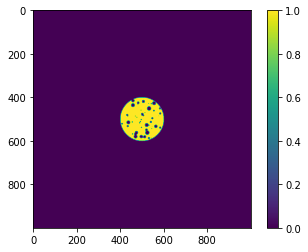

In [484]:
aperature_function = create_dirty_mask(IMAGE_SIZE, IMAGE_SIZE, radius=APERTURE_RADIUS)
# aperature_function = np.zeros((IMAGE_SIZE,IMAGE_SIZE))
# aperature_function[100:150, 120:130] = 1

plt.imshow(aperature_function.astype(np.uint8))
plt.colorbar()

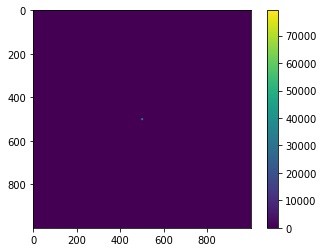

In [499]:
aperture = aperature_function.astype(float)
psf_a = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(aperture))) * .01
image = np.abs(psf_a)**2

#circle_fourier = np.abs(np.fft.fft2(aperature_function.astype(float))) ** 2
plt.imshow(image)
plt.colorbar()

In [460]:
a = np.ones((2,2,2))
np.linalg.norm(a, ord=1, axis=-1)

array([[2., 2.],
       [2., 2.]])

In [461]:
origin = (200, 100)
depth = 300

def create_phase_matrix(height, width, origin, depth):
    x = np.arange(0, height, 1)
    y = np.arange(0, width,  1)
    
    xv, yv = np.meshgrid(x, y)
    zv = np.zeros_like(xv)
    
    grid = np.stack((xv, yv, zv), axis=-1)
    
    light_pos = np.array([*origin, depth])
    
    norms = np.linalg.norm(light_pos - grid, ord=2, axis=-1)
    assert norms.shape == (height, width)
    
    ratio = depth / norms
    
    phase = np.arcsin(ratio) # in interval [-pi/2, pi/2]
    return phase # in interval [0, pi]

#     return light_pos - grid
    

In [462]:
create_phase_matrix(4,4,(1,1),1)

array([[0.61547971, 0.78539816, 0.61547971, 0.42053434],
       [0.78539816, 1.57079633, 0.78539816, 0.46364761],
       [0.61547971, 0.78539816, 0.61547971, 0.42053434],
       [0.42053434, 0.46364761, 0.42053434, 0.33983691]])

In [463]:
phase = create_phase_matrix(IMAGE_SIZE, IMAGE_SIZE, LIGHT_SOURCE_ORIGIN, 1)
phase = np.exp(phase * -1j)
pupil_func = aperature_function.astype(float) * phase


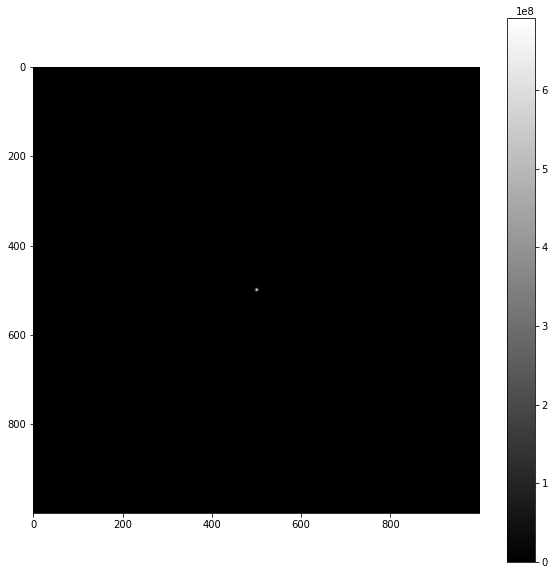

In [464]:
pupil_fourier = np.absolute(np.fft.fft2(pupil_func))**2
pupil_fourier = np.fft.fftshift(pupil_fourier)

plt.figure(figsize=(10,10))
plt.imshow(pupil_fourier, cmap='gray')
plt.colorbar()

## Spectral Response Function

In [465]:
from scipy.stats import norm

In [466]:
wavelengths = np.arange(380, 745, 5)

In [467]:
mu_R = np.random.uniform(620, 640, 1)
mu_G = np.random.uniform(540, 560, 1)
mu_B = np.random.uniform(460, 480, 1)

sigma_R = np.random.uniform(50, 60, 1)
sigma_G = np.random.uniform(50, 60, 1)
sigma_B = np.random.uniform(50, 60, 1)

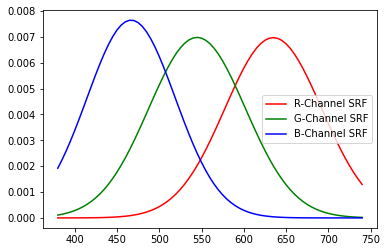

In [468]:
# Example SRF
plt.plot(wavelengths, norm.pdf(wavelengths, mu_R, sigma_R), color='r', label='R-Channel SRF')
plt.plot(wavelengths, norm.pdf(wavelengths, mu_G, sigma_G), color='g', label='G-Channel SRF')
plt.plot(wavelengths, norm.pdf(wavelengths, mu_B, sigma_B), color='b', label='B-Channel SRF')
plt.legend()

In [469]:
SRF_R = norm.pdf(wavelengths, mu_R, sigma_R)[None, :]
SRF_G = norm.pdf(wavelengths, mu_G, sigma_G)[None, :]
SRF_B = norm.pdf(wavelengths, mu_B, sigma_B)[None, :]

In [470]:
SRF = np.concatenate((SRF_R, SRF_G, SRF_B), axis=0)
SRF.shape

(3, 73)

## Combining

In [471]:
psf = np.repeat(np.expand_dims(pupil_fourier, axis=0), 73, axis=0)
psf = psf.reshape(73, -1)

In [472]:
psf.shape

(73, 1000000)

In [473]:
psf_rgb = (SRF @ psf)

In [474]:
psf_rgb = psf_rgb.reshape(3, IMAGE_SIZE, IMAGE_SIZE)

In [475]:
psf_rgb = psf_rgb / np.max(psf_rgb)

In [476]:
psf_rgb

array([[[5.62282953e-09, 1.60348678e-07, 5.22920943e-07, ...,
         8.69130257e-07, 5.23079051e-07, 1.60501972e-07],
        [4.08067150e-09, 1.62749842e-07, 4.47928981e-07, ...,
         1.11201358e-06, 6.00945429e-07, 1.56509100e-07],
        [3.14950136e-09, 1.80271260e-07, 4.37879538e-07, ...,
         1.25227834e-06, 6.36699838e-07, 1.43923243e-07],
        ...,
        [1.94531993e-08, 1.46537194e-07, 6.43655825e-07, ...,
         7.00215594e-07, 5.29726614e-07, 2.26503780e-07],
        [3.17538786e-09, 1.43732370e-07, 6.36353096e-07, ...,
         5.47863432e-07, 4.37969261e-07, 1.80409651e-07],
        [4.08955515e-09, 1.56328288e-07, 6.00680788e-07, ...,
         6.34063995e-07, 4.48015777e-07, 1.62883271e-07]],

       [[5.78558987e-09, 1.64990186e-07, 5.38057591e-07, ...,
         8.94288398e-07, 5.38220276e-07, 1.65147917e-07],
        [4.19879201e-09, 1.67460855e-07, 4.60894887e-07, ...,
         1.14420231e-06, 6.18340601e-07, 1.61039465e-07],
        [3.24066790e-09, 

In [477]:
psf_rgb

array([[[5.62282953e-09, 1.60348678e-07, 5.22920943e-07, ...,
         8.69130257e-07, 5.23079051e-07, 1.60501972e-07],
        [4.08067150e-09, 1.62749842e-07, 4.47928981e-07, ...,
         1.11201358e-06, 6.00945429e-07, 1.56509100e-07],
        [3.14950136e-09, 1.80271260e-07, 4.37879538e-07, ...,
         1.25227834e-06, 6.36699838e-07, 1.43923243e-07],
        ...,
        [1.94531993e-08, 1.46537194e-07, 6.43655825e-07, ...,
         7.00215594e-07, 5.29726614e-07, 2.26503780e-07],
        [3.17538786e-09, 1.43732370e-07, 6.36353096e-07, ...,
         5.47863432e-07, 4.37969261e-07, 1.80409651e-07],
        [4.08955515e-09, 1.56328288e-07, 6.00680788e-07, ...,
         6.34063995e-07, 4.48015777e-07, 1.62883271e-07]],

       [[5.78558987e-09, 1.64990186e-07, 5.38057591e-07, ...,
         8.94288398e-07, 5.38220276e-07, 1.65147917e-07],
        [4.19879201e-09, 1.67460855e-07, 4.60894887e-07, ...,
         1.14420231e-06, 6.18340601e-07, 1.61039465e-07],
        [3.24066790e-09, 

In [478]:
psf_rgb.sum(axis=0)

array([[1.69526559e-08, 4.83446271e-07, 1.57659036e-06, ...,
        2.62040065e-06, 1.57706705e-06, 4.83908446e-07],
       [1.23030975e-08, 4.90685705e-07, 1.35049193e-06, ...,
        3.35268631e-06, 1.81183175e-06, 4.71870060e-07],
       [9.49564850e-09, 5.43512232e-07, 1.32019317e-06, ...,
        3.77558020e-06, 1.91963018e-06, 4.33924096e-07],
       ...,
       [5.86507899e-08, 4.41805075e-07, 1.94060226e-06, ...,
        2.11112820e-06, 1.59710924e-06, 6.82901842e-07],
       [9.57369548e-09, 4.33348617e-07, 1.91858476e-06, ...,
        1.65179118e-06, 1.32046368e-06, 5.43929479e-07],
       [1.23298814e-08, 4.71324918e-07, 1.81103387e-06, ...,
        1.91168320e-06, 1.35075361e-06, 4.91087990e-07]])

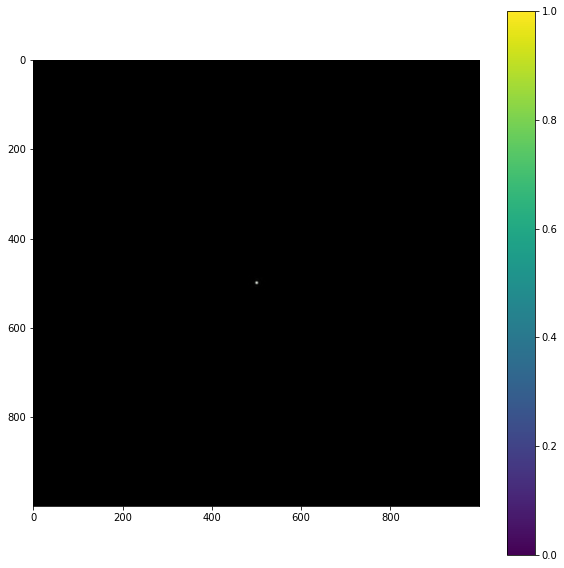

In [479]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(psf_rgb, (1, 2, 0)))
plt.colorbar()